In [6]:
import numpy as np
from astropy import units as u

from tardis.model.mesh import (
    HomologousRadial1DMesh,
    MeshLocation,
    MeshQuantity,
    Radial1DMesh,
)

# TARDIS Geometry Mesh Classes

This notebook demonstrates the TARDIS geometry mesh classes in `tardis.model.mesh`.

## Core Components

- **`MeshLocation`**: Enum (INTERFACE or VOLUME)
- **`MeshQuantity`**: Container binding physical quantities to mesh locations
- **`Radial1DMesh`**: Spatial mesh with interface-defined radii
- **`HomologousRadial1DMesh`**: Velocity-based mesh with homologous expansion

In [2]:
# Create a mesh quantity
radius_data = u.Quantity([1e8, 2e8, 3e8, 4e8], "cm")
radius_mq = MeshQuantity(
    data=radius_data, defined_at=MeshLocation.INTERFACE, name="radius"
)

print(f"Data: {radius_mq.data}")
print(f"Defined at: {radius_mq.defined_at}")
print(f"Name: {radius_mq.name}")

Data: [1.e+08 2.e+08 3.e+08 4.e+08] cm
Defined at: MeshLocation.INTERFACE
Name: radius


## 1. Radial1DMesh: Spatial Mesh

Create a 1D radial mesh from cell interface radii. N+1 interfaces define N cells.

In [7]:
# Create spatial mesh from interface radii
RADIUS_INTERFACES = u.Quantity([1e8, 2e8, 3e8, 4e8, 5e8], "cm")
mesh = Radial1DMesh.from_cell_interfaces(RADIUS_INTERFACES)

print(f"Number of cells: {mesh.n_cells}")
print(f"Cell IDs: {mesh.cell_id}")
print(f"Interface radii:\n{mesh.radius.data}")
print(f"Defined at: {mesh.radius.defined_at}")

Number of cells: 4
Cell IDs: [0 1 2 3]
Interface radii:
[1.e+08 2.e+08 3.e+08 4.e+08 5.e+08] cm
Defined at: MeshLocation.INTERFACE


## 2. HomologousRadial1DMesh: Velocity-Based Mesh

Create from velocity interfaces and convert to spatial mesh using $r = v \times t_{\text{explosion}}$.

In [8]:
# Create homologous mesh
VELOCITY_INTERFACES = u.Quantity([1000, 5000, 10000, 15000, 20000], "km/s")
TIME_EXPLOSION = u.Quantity(10, "day")

hom_mesh = HomologousRadial1DMesh.from_velocity_interfaces(
    VELOCITY_INTERFACES, TIME_EXPLOSION
)

print(f"Velocity interfaces: {hom_mesh.velocity.data}")
print(f"Time explosion: {hom_mesh.time_explosion}")

Velocity interfaces: [ 1000.  5000. 10000. 15000. 20000.] km / s
Time explosion: 10.0 d


### Convert to Spatial Mesh

In [9]:
# Convert to spatial mesh
spatial_mesh, velocity_field = hom_mesh.to_spatial_mesh()

print(f"Number of cells: {spatial_mesh.n_cells}")
print(f"Radius interfaces:\n{spatial_mesh.radius.data.to('km')}")
print(f"\nVelocity field preserved: {velocity_field.data}")

Number of cells: 4
Radius interfaces:
[8.640e+08 4.320e+09 8.640e+09 1.296e+10 1.728e+10] km

Velocity field preserved: [ 1000.  5000. 10000. 15000. 20000.] km / s


## 3. Practical Example: Type Ia Supernova Mesh

In [10]:
# Define realistic SN Ia parameters
N_SHELLS = 20
V_INNER = 8000  # km/s
V_OUTER = 20000  # km/s
T_EXPLOSION = 10  # days

velocity_interfaces = (
    np.linspace(V_INNER, V_OUTER, N_SHELLS + 1) * u.km / u.s
)
time_exp = T_EXPLOSION * u.day

sn_hom_mesh = HomologousRadial1DMesh.from_velocity_interfaces(
    velocity_interfaces, time_exp
)
sn_spatial_mesh, sn_velocity = sn_hom_mesh.to_spatial_mesh()

print("Supernova Mesh:")
print(f"  Shells: {sn_spatial_mesh.n_cells}")
print(f"  Inner radius: {sn_spatial_mesh.radius.data[0]:.2e}")
print(f"  Outer radius: {sn_spatial_mesh.radius.data[-1]:.2e}")
print(f"  Velocity range: {sn_velocity.data[0]} to {sn_velocity.data[-1]}")

Supernova Mesh:
  Shells: 20
  Inner radius: 6.91e+14 cm
  Outer radius: 1.73e+15 cm
  Velocity range: 8000.0 km / s to 20000.0 km / s


### Calculate Cell Properties

In [11]:
# Cell volumes (spherical shells)
r_inner = sn_spatial_mesh.radius.data[:-1]
r_outer = sn_spatial_mesh.radius.data[1:]
cell_volumes = (4.0 / 3.0) * np.pi * (r_outer**3 - r_inner**3)

print(f"Cell volumes (first 3): {cell_volumes[:3]}")

# Cell mid-point radii
r_mid = 0.5 * (r_inner + r_outer)
print(f"Mid-point radii (first 3): {r_mid[:3]}")

Cell volumes (first 3): [3.35156472e+44 3.85342410e+44 4.39029691e+44] cm3
Mid-point radii (first 3): [7.1712e+14 7.6896e+14 8.2080e+14] cm


## 4. Visualization

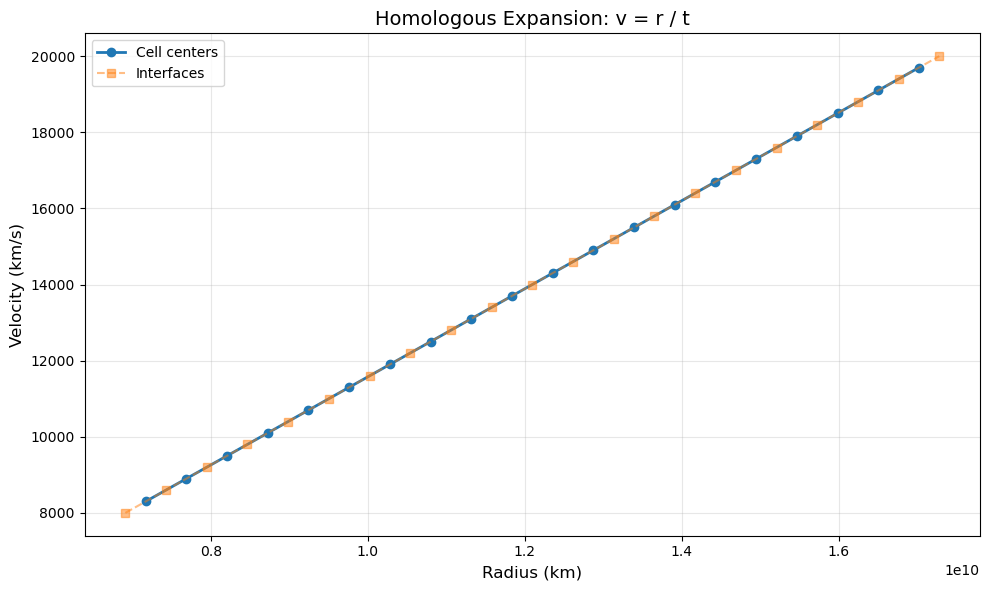

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

v_mid = 0.5 * (sn_velocity.data[:-1] + sn_velocity.data[1:])
ax.plot(
    r_mid.to("km").value,
    v_mid.to("km/s").value,
    "o-",
    label="Cell centers",
    linewidth=2,
)
ax.plot(
    sn_spatial_mesh.radius.data.to("km").value,
    sn_velocity.data.to("km/s").value,
    "s--",
    alpha=0.5,
    label="Interfaces",
)
ax.set_xlabel("Radius (km)", fontsize=12)
ax.set_ylabel("Velocity (km/s)", fontsize=12)
ax.set_title("Homologous Expansion: v = r / t", fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

The TARDIS geometry classes in `tardis.model.mesh` provide:
- Type-safe quantity handling with `astropy.units`
- Clear location semantics (INTERFACE vs. VOLUME)
- Easy conversion between velocity and spatial representations
- Foundation for TARDIS supernova model spatial structure